<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Input/Loading-Data" data-toc-modified-id="Input/Loading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input/Loading Data</a></span></li><li><span><a href="#Data-Transformation/-Preprocessing" data-toc-modified-id="Data-Transformation/-Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Transformation/ Preprocessing</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Features-Selection" data-toc-modified-id="Features-Selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features Selection</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Key-Take-Aways" data-toc-modified-id="Key-Take-Aways-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Key Take Aways</a></span></li><li><span><a href="#Future-Directions" data-toc-modified-id="Future-Directions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Future Directions</a></span></li></ul></div>

# Objective

1) Predict when employees churn
2) Find main factors for employee churn, make sense with it, explain
3) what variable will help explain more?

# Input/Loading Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
#import dataframe
df = pd.read_csv(r'employee_retention_data.csv')

In [3]:
#print head of dataframe
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


# Data Transformation/ Preprocessing

In [4]:
import matplotlib.pyplot as plt
from datetime import date

In [5]:
#Turning join date and quit date to integer days starting from 2011-01-24
num_days=[]
for i in range(len(df)):
    if type(df.quit_date[i]) != float:
        temp = date(int(df.quit_date[i][:4]), int(df.quit_date[i][5:7]), int(df.quit_date[i][8:10])) \
                - date(int(df.join_date[i][:4]), int(df.join_date[i][5:7]), int(df.join_date[i][8:10]))
        temp = temp.days
    else:
        temp = date(2015, 12, 13) \
                - date(int(df.join_date[i][:4]), int(df.join_date[i][5:7]), int(df.join_date[i][8:10]))
        temp = temp.days
    num_days = num_days + [temp]
df['days_in_company'] = num_days

In [6]:
#Turning join date and quit date to day of the week
quit_dayofweek=[]
join_dayofweek=[]
#date.today().weekday()
for i in range(len(df)):
    if type(df.quit_date[i]) != float:
        quit_dayofweek = quit_dayofweek + \
            [date(int(df.quit_date[i][:4]), int(df.quit_date[i][5:7]), int(df.quit_date[i][8:10])).weekday()]
    else:
        quit_dayofweek = quit_dayofweek + [date(2015, 12, 13).weekday()]
    join_dayofweek = join_dayofweek + \
        [date(int(df.join_date[i][:4]), int(df.join_date[i][5:7]), int(df.join_date[i][8:10])).weekday()]
df['join_dayofweek'] = join_dayofweek
df['quit_dayofweek'] = quit_dayofweek

In [7]:
#Turning join date and quit date to month of the year
quit_month=[]
join_month=[]
for i in range(len(df)):
    if type(df.quit_date[i]) != float:
        quit_month = quit_month + [int(df.quit_date[i][5:7])]
    else:
        quit_month = quit_month + [12]                          
    join_month = join_month + [int(df.join_date[i][5:7])]
df['join_month'] = join_month
df['quit_month'] = quit_month

In [8]:
#New column for Churned v. not churned
churn=[]
for i in range(len(df)):
    if type(df.quit_date[i]) != float:
        churn.append(1)
    else:
        churn.append(0)
df['churn'] = churn

In [9]:
#Finding out the head count of each company over time
join_date = df.join_date
quit_date = df.quit_date
qd=[]
jd=[]
for i in range(len(df)):
    if type(quit_date[i]) != float:
        qd = qd + [(date(int(quit_date[i][:4]), int(quit_date[i][5:7]), int(quit_date[i][8:10])) \
              - date(2011,1,24)).days]
    else:
        qd = qd + [(date(2015,12,13) - date(2011,1,24)).days]
    jd = jd + [(date(int(join_date[i][:4]), int(join_date[i][5:7]), int(join_date[i][8:10])) \
              - date(2011,1,24)).days]
df['join_date_mod']=jd
df['quit_date_mod']=qd
time=list(range(max(qd)))
all_companies=[]
for k in range(1,max(df.company_id)+1):
    temp=np.zeros(max(qd))
    jd_temp = df[df.company_id == k].join_date_mod.reset_index().drop('index',axis=1)
    qd_temp = df[df.company_id == k].quit_date_mod.reset_index().drop('index',axis=1)
    jd_temp = np.transpose(jd_temp).values[0]
    qd_temp = np.transpose(qd_temp).values[0]
    for i in range(len(time)):
        for j in range(len(jd_temp)):
            if ((qd_temp[j]>i) and (jd_temp[j]<i)):
                temp[i]+=1
    all_companies = all_companies + [temp]

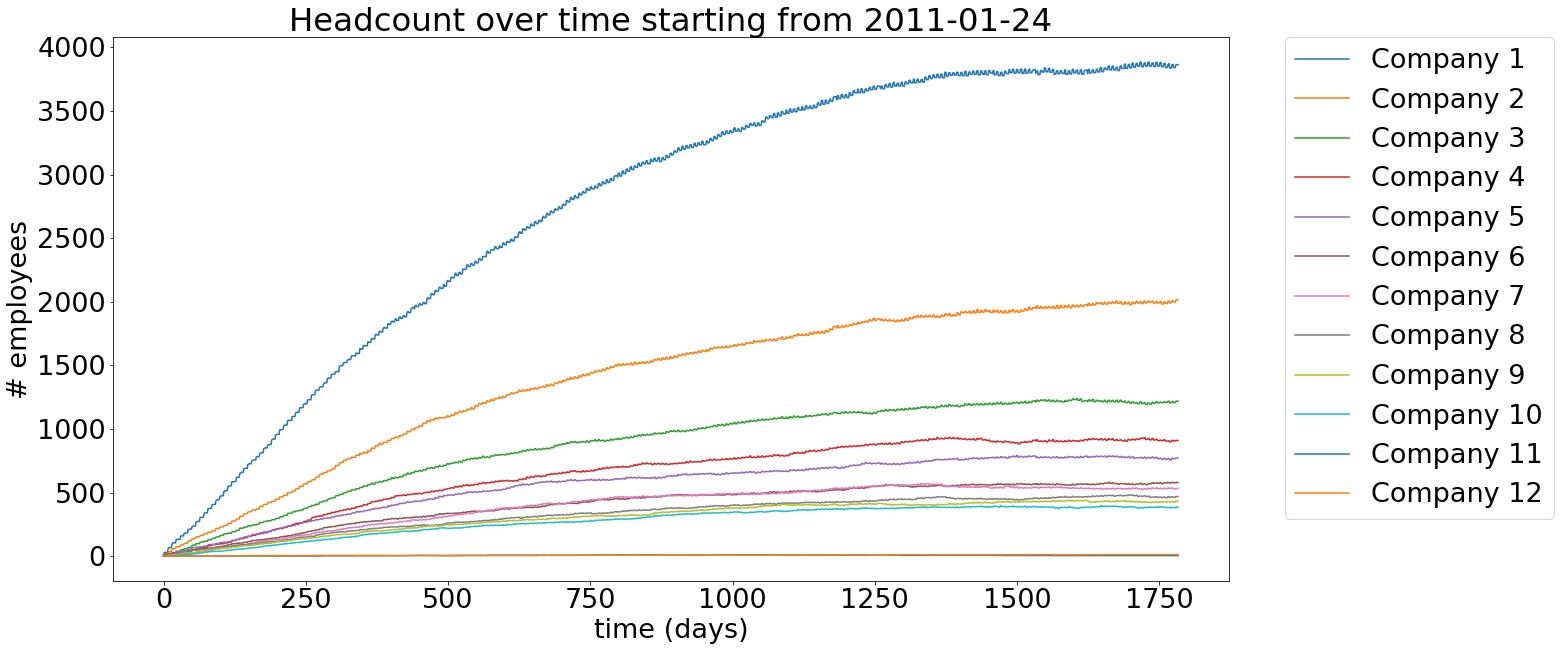

In [10]:
#Visualizing headcount of companies over time
plt.rcParams.update({'font.size': 27})
plt.rcParams['figure.figsize'] = 20, 10
for i in range(12):
    plt.plot(time, all_companies[i], label="Company "+str(i+1))
plt.xlabel('time (days)')
plt.ylabel('# employees')
plt.title('Headcount over time starting from 2011-01-24')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# EDA

In [11]:
#explore summary statistics
df.describe()

,employee_id,company_id,seniority,salary,days_in_company,join_dayofweek,quit_dayofweek,join_month,quit_month,churn,join_date_mod,quit_date_mod
count,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478,574.319083,0.355558,4.770869,6.494899,9.019796,0.546919,887.402518,1461.721601
std,288909.026101,2.700011,8.089520,76058.184573,361.592379,0.722614,1.285570,3.401531,3.703077,0.497804,514.342577,409.509553
min,36.000000,1.000000,1.000000,17000.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,262.000000
25%,250133.750000,1.000000,7.000000,79000.000000,333.000000,0.000000,4.000000,4.000000,6.000000,0.000000,441.000000,1187.000000
50%,500793.000000,2.000000,14.000000,123000.000000,424.000000,0.000000,4.000000,6.000000,11.000000,1.000000,882.000000,1698.000000
75%,753137.250000,5.000000,21.000000,187000.000000,781.000000,0.000000,6.000000,9.000000,12.000000,1.000000,1332.000000,1784.000000
max,999969.000000,12.000000,99.000000,408000.000000,1777.000000,4.000000,6.000000,12.000000,12.000000,1.000000,1781.000000,1784.000000


In [12]:
#how many department types?
set(df.dept)

{'customer_service',
 'data_science',
 'design',
 'engineer',
 'marketing',
 'sales'}

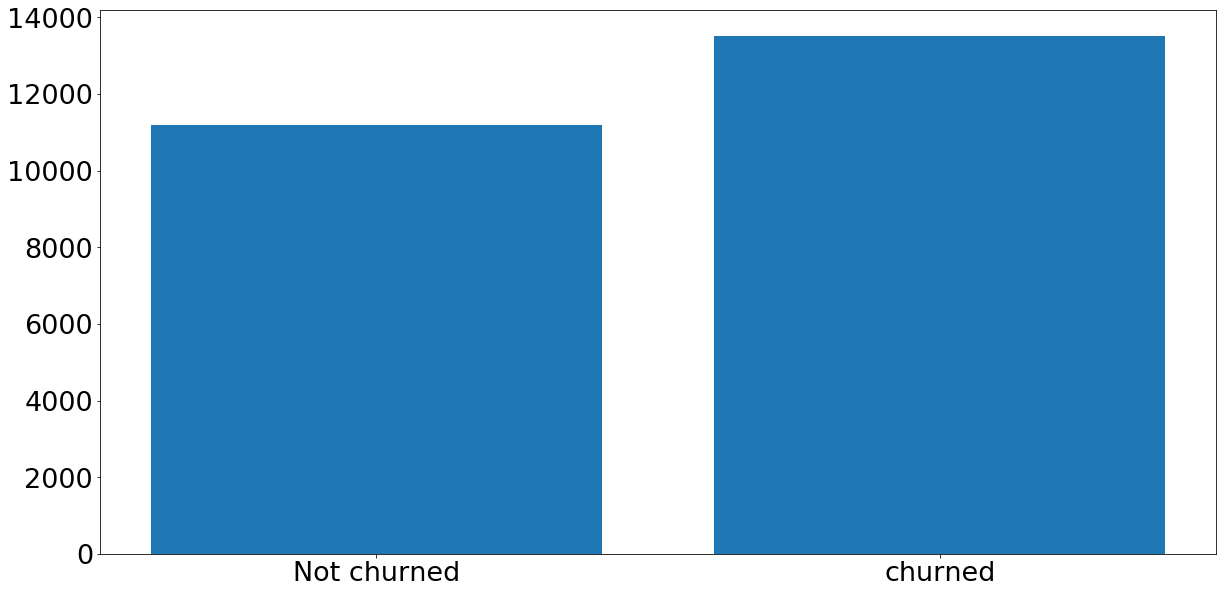

In [13]:
#How many employees churned?
not_churned = sum(df.quit_date.isnull())
churned = len(df)-sum(df.quit_date.isnull())
x = [0,1]
y = [not_churned, churned]
plt.bar(x, y)
plt.xticks(x, ('Not churned', 'churned'))
plt.show()

>Classes seem balanced in the data

In [14]:
#how many companies?
set(df.company_id)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [15]:
#Senority distribution?
df.groupby('seniority').count().company_id

seniority
1      861
2      942
3      881
4      895
5      936
6      950
7      928
8     1008
9      944
10     927
11     924
12     988
13     894
14     920
15     911
16     936
17     893
18     872
19     910
20     844
21     782
22     764
23     785
24     743
25     715
26     694
27     642
28     585
29     626
98       1
99       1
Name: company_id, dtype: int64

>More than 30 years of senority is probably nonsensical data, I should drop the two data point

In [16]:
df=df[df.seniority<30]

In [17]:
#Num of employees ever worked in each companies
df.groupby('company_id').count().employee_id

company_id
1     8485
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     864
11      16
12      24
Name: employee_id, dtype: int64

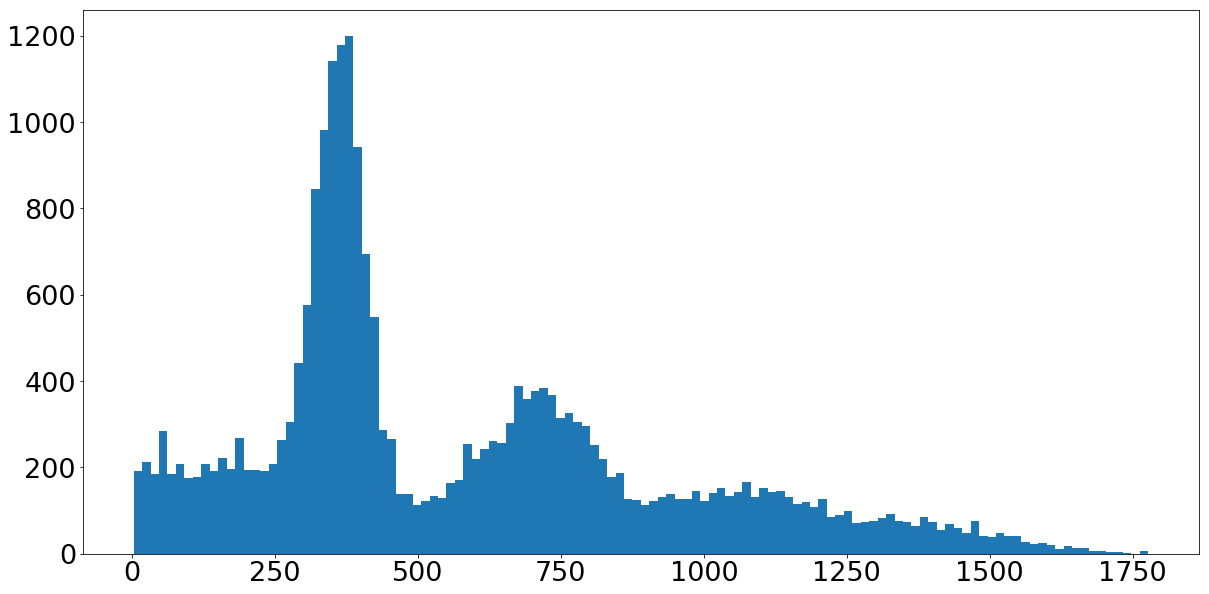

In [18]:
#Length of stay visualized
plt.rcParams.update({'font.size': 27})
plt.rcParams['figure.figsize'] = 20, 10
plt.hist(df.days_in_company, bins=120)
plt.show()

>Length of stay at companies peak around 365 days (1yr) or around 730 days (2yr)

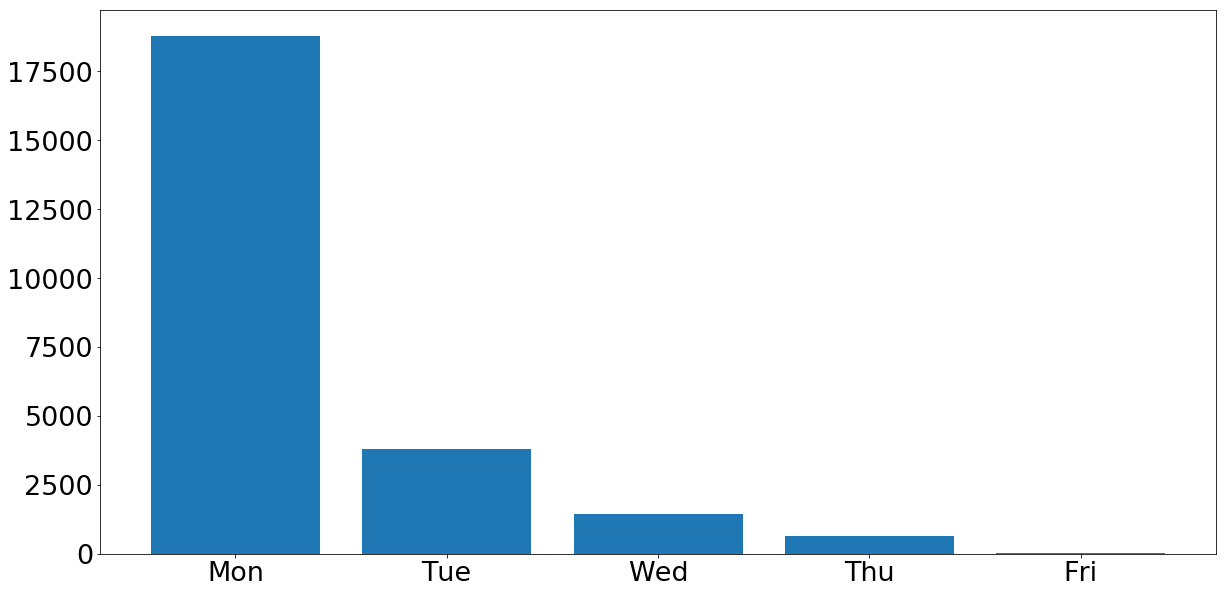

In [19]:
#Join date as day of the week
x = [0,1,2,3,4]
y = df.groupby('join_dayofweek').join_dayofweek.count()
plt.bar(x, y)
plt.xticks(x, ('Mon','Tue','Wed','Thu','Fri'))
plt.show()

>Most employees joined on Monday

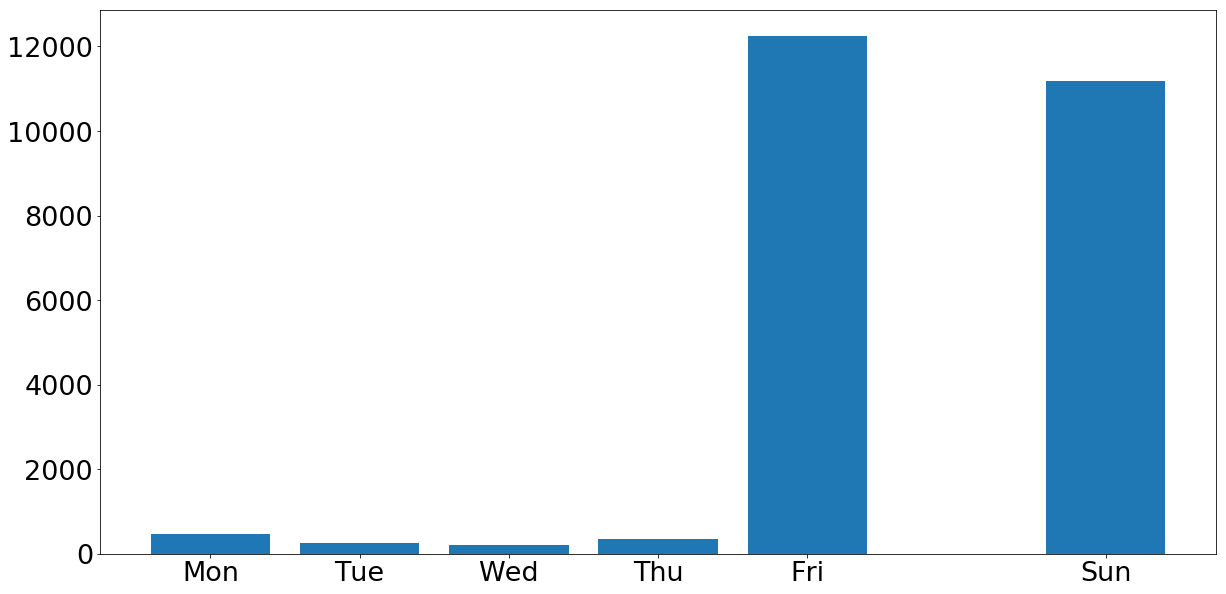

In [20]:
#Quit date as day of the week
x = [0,1,2,3,4,6]
y = df.groupby('quit_dayofweek').quit_dayofweek.count()
plt.bar(x, y)
plt.xticks(x, ('Mon','Tue','Wed','Thu','Fri','Sun'))
plt.show()

>Most employees quited on Friday or Sunday

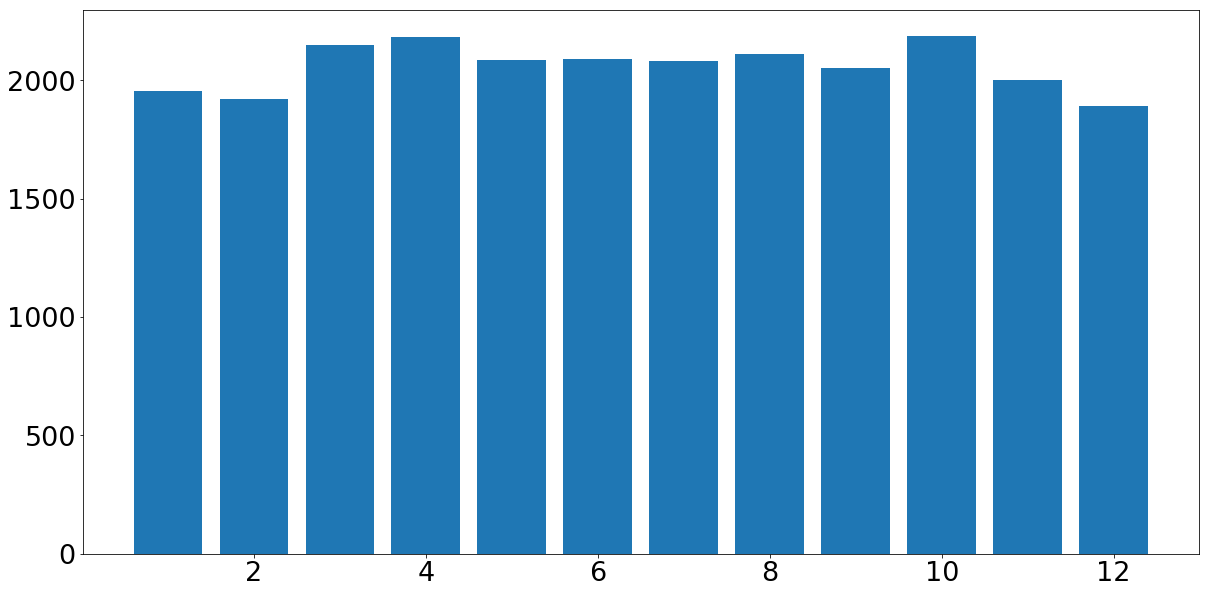

In [21]:
#Employee join month
x = list(range(1,13))
y = df.groupby('join_month').join_month.count()
plt.bar(x, y)
plt.show()

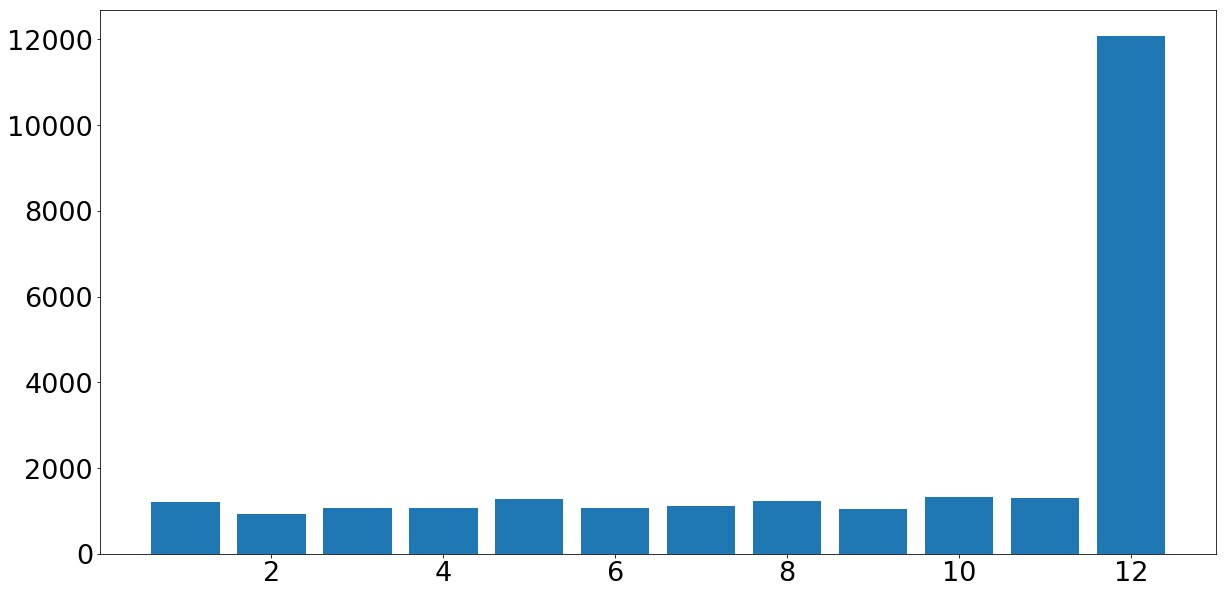

In [22]:
#Employee quit month
x = list(range(1,13))
y = df.groupby('quit_month').quit_month.count()
plt.bar(x, y)
plt.show()

>Majority of employees left in December

# Features Selection

In [23]:
#One hot encoding all features
df = df.join(pd.get_dummies(df.join_dayofweek,prefix='join_dayofweek'))
df = df.join(pd.get_dummies(df.quit_dayofweek,prefix='quit_dayofweek'))
df = df.join(pd.get_dummies(df.join_month,prefix='join_month'))
df = df.join(pd.get_dummies(df.quit_month,prefix='quit_month'))
df = df.join(pd.get_dummies(df.dept,prefix='dept'))
df = df.join(pd.get_dummies(df.company_id,prefix='company'))

In [24]:
#Selecting only departed employees as training and testing data
df_churned = df[df.churn == 1].reset_index() \
    .drop(['employee_id','company_id','index','churn','dept','join_date','quit_date','join_month','quit_month',\
           'join_dayofweek','quit_dayofweek','join_date_mod','quit_date_mod'], axis=1)

In [25]:
df_churned_x = df_churned.drop(['days_in_company'], axis=1)
df_churned_y = df_churned['days_in_company']

In [26]:
#all items in the dataframe
list(df_churned_x)

['seniority',
 'salary',
 'join_dayofweek_0',
 'join_dayofweek_1',
 'join_dayofweek_2',
 'join_dayofweek_3',
 'join_dayofweek_4',
 'quit_dayofweek_0',
 'quit_dayofweek_1',
 'quit_dayofweek_2',
 'quit_dayofweek_3',
 'quit_dayofweek_4',
 'quit_dayofweek_6',
 'join_month_1',
 'join_month_2',
 'join_month_3',
 'join_month_4',
 'join_month_5',
 'join_month_6',
 'join_month_7',
 'join_month_8',
 'join_month_9',
 'join_month_10',
 'join_month_11',
 'join_month_12',
 'quit_month_1',
 'quit_month_2',
 'quit_month_3',
 'quit_month_4',
 'quit_month_5',
 'quit_month_6',
 'quit_month_7',
 'quit_month_8',
 'quit_month_9',
 'quit_month_10',
 'quit_month_11',
 'quit_month_12',
 'dept_customer_service',
 'dept_data_science',
 'dept_design',
 'dept_engineer',
 'dept_marketing',
 'dept_sales',
 'company_1',
 'company_2',
 'company_3',
 'company_4',
 'company_5',
 'company_6',
 'company_7',
 'company_8',
 'company_9',
 'company_10',
 'company_11',
 'company_12']

In [27]:
#Scaling features
from sklearn import preprocessing
X_scaled = preprocessing.scale(df_churned_x)

In [28]:
#Test-train split of the data set
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_scaled, df_churned_y, train_size=0.6)

/Users/godinechan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
print("train_x size :: ", train_x.shape)
print("train_y size :: ", train_y.shape)
print("test_x size :: ", test_x.shape)
print("test_y size :: ", test_y.shape)

train_x size ::  (8104, 55)
train_y size ::  (8104,)
test_x size ::  (5404, 55)
test_y size ::  (5404,)


# Model

>Two models: Lasso and Random Forest

In [30]:
import sklearn.datasets
import sklearn.cross_validation as cv
from sklearn import linear_model
lasso = linear_model.Lasso()
lasso.set_params(alpha=0.01)
lasso.fit(train_x, train_y)
predicted = lasso.predict(test_x)

/Users/godinechan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/godinechan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [31]:
lasso.coef_

array([-27.05863582,  50.42055787,   0.        ,  10.72430613,
        -1.46442099,  -3.76392426,  -4.91553558,   7.72641636,
        -1.83729784,  -3.58642518,  -6.39314484,   0.        ,
         0.        ,   4.07643122,   8.77956572,  13.04014372,
         9.00447426,  16.32143498,   1.62386916,   7.74909046,
        -0.10321006, -19.50742548, -16.80391368, -12.32899449,
       -22.32614631,  -8.83492754,  -9.89711074, -20.81338493,
       -14.4453511 ,  -6.98388642,  -5.68009773,   3.11818062,
        -1.50166185,  20.58040103,  19.23487832,  13.41401436,
         1.49793477,  23.39601793,   4.4373128 ,   0.26477908,
        -0.        ,  -2.2837036 ,  -4.84909138,  -2.73701583,
         1.39189585,   4.40989207,  -0.05341486,   6.95685688,
         0.        ,  -1.08370703,  -5.02960584,  -0.        ,
         6.05864054,  -2.07169036,  -2.84276423])

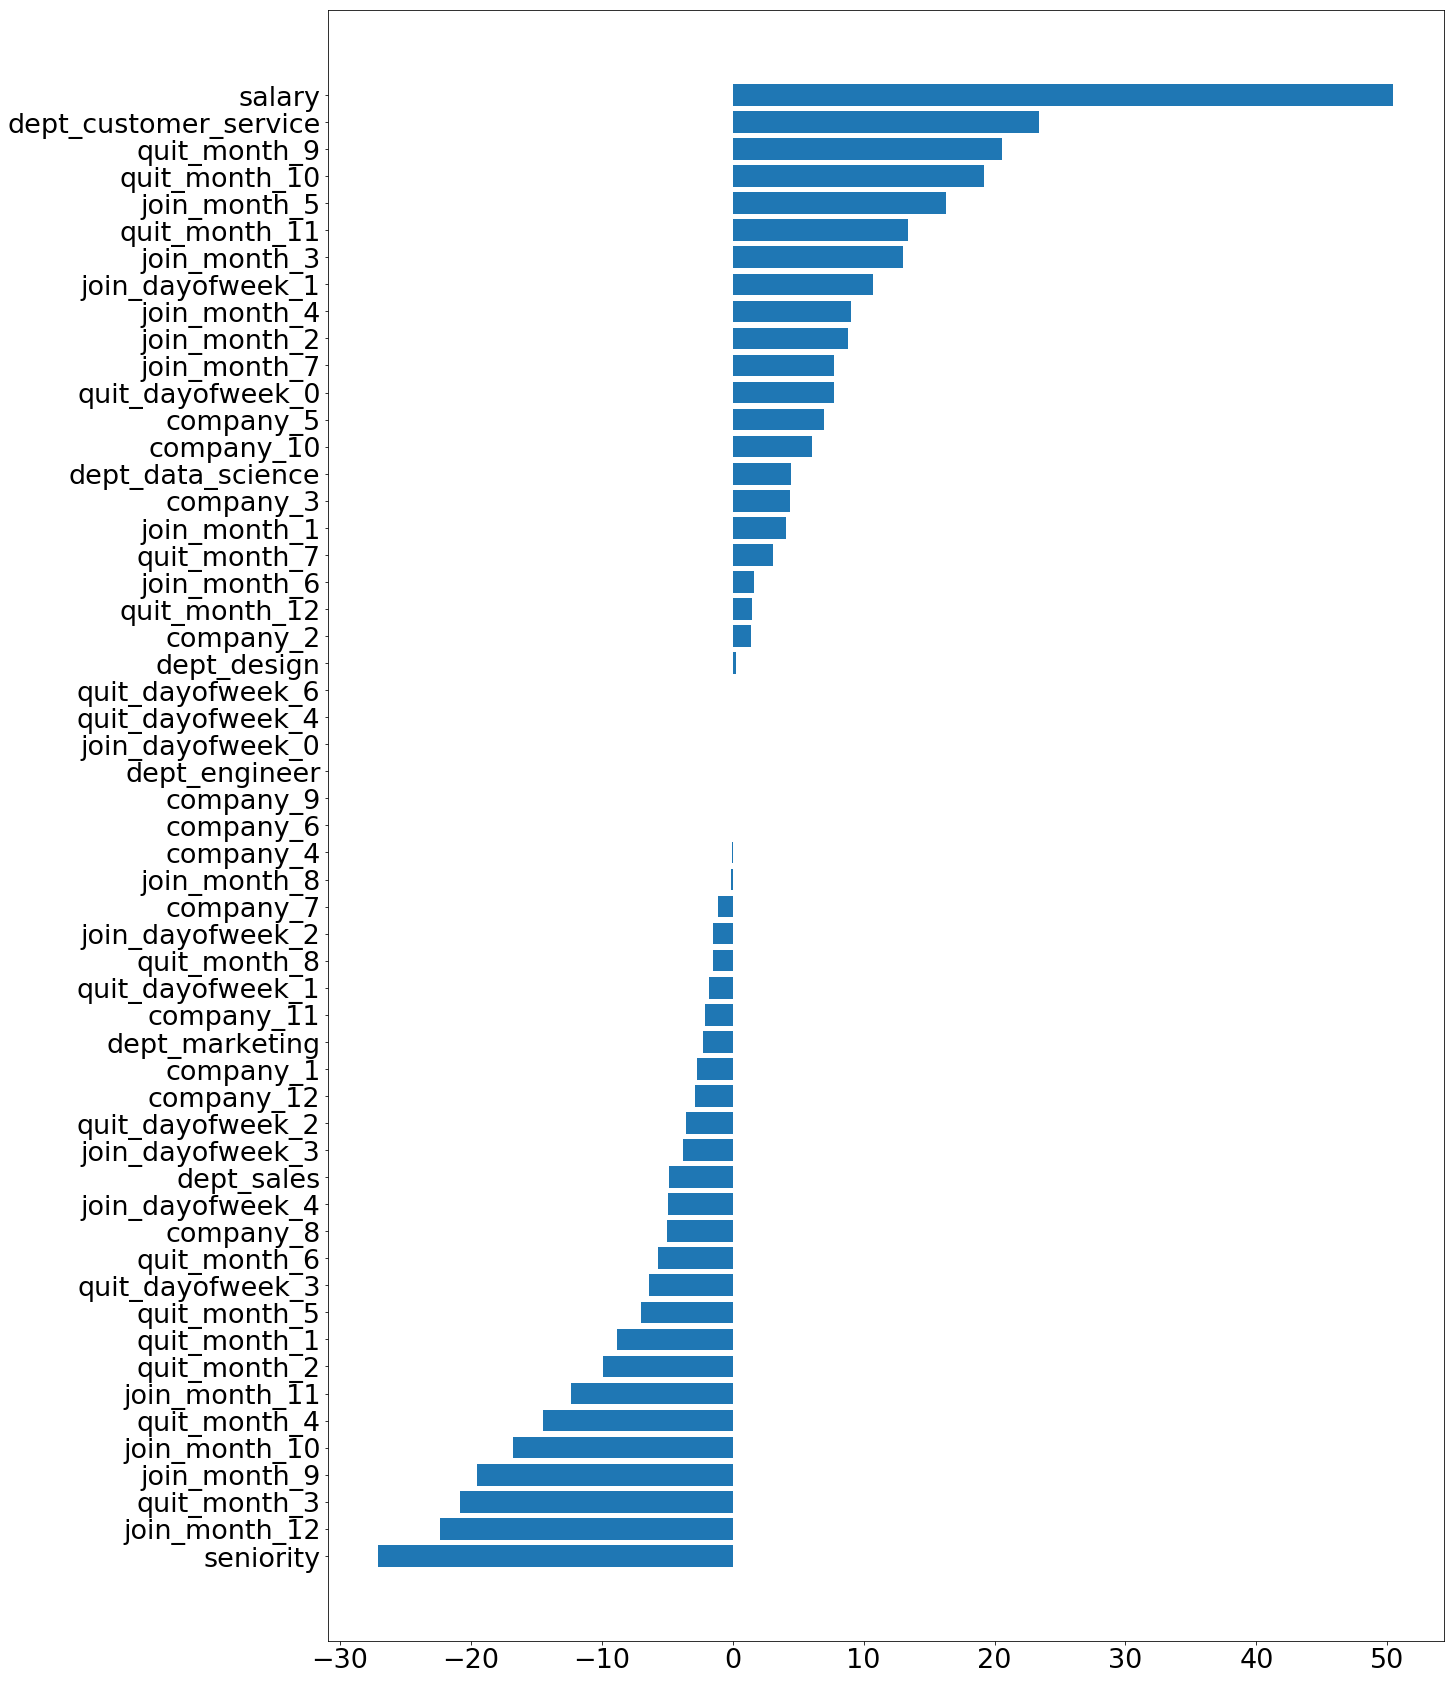

In [32]:
a = zip(lasso.coef_, df_churned_x)
a = sorted(a)
xplot = [x[1] for x in a]
yplot = [y[0] for y in a]
dummy=list(range(len(a)))
plt.rcParams.update({'font.size': 27})
plt.rcParams['figure.figsize'] = 20, 30
plt.close()
plt.barh(dummy,yplot,tick_label=xplot)
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
RMSE=mean_squared_error(test_y, predicted)**(1/2)
RMSE

319.00090189027793

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

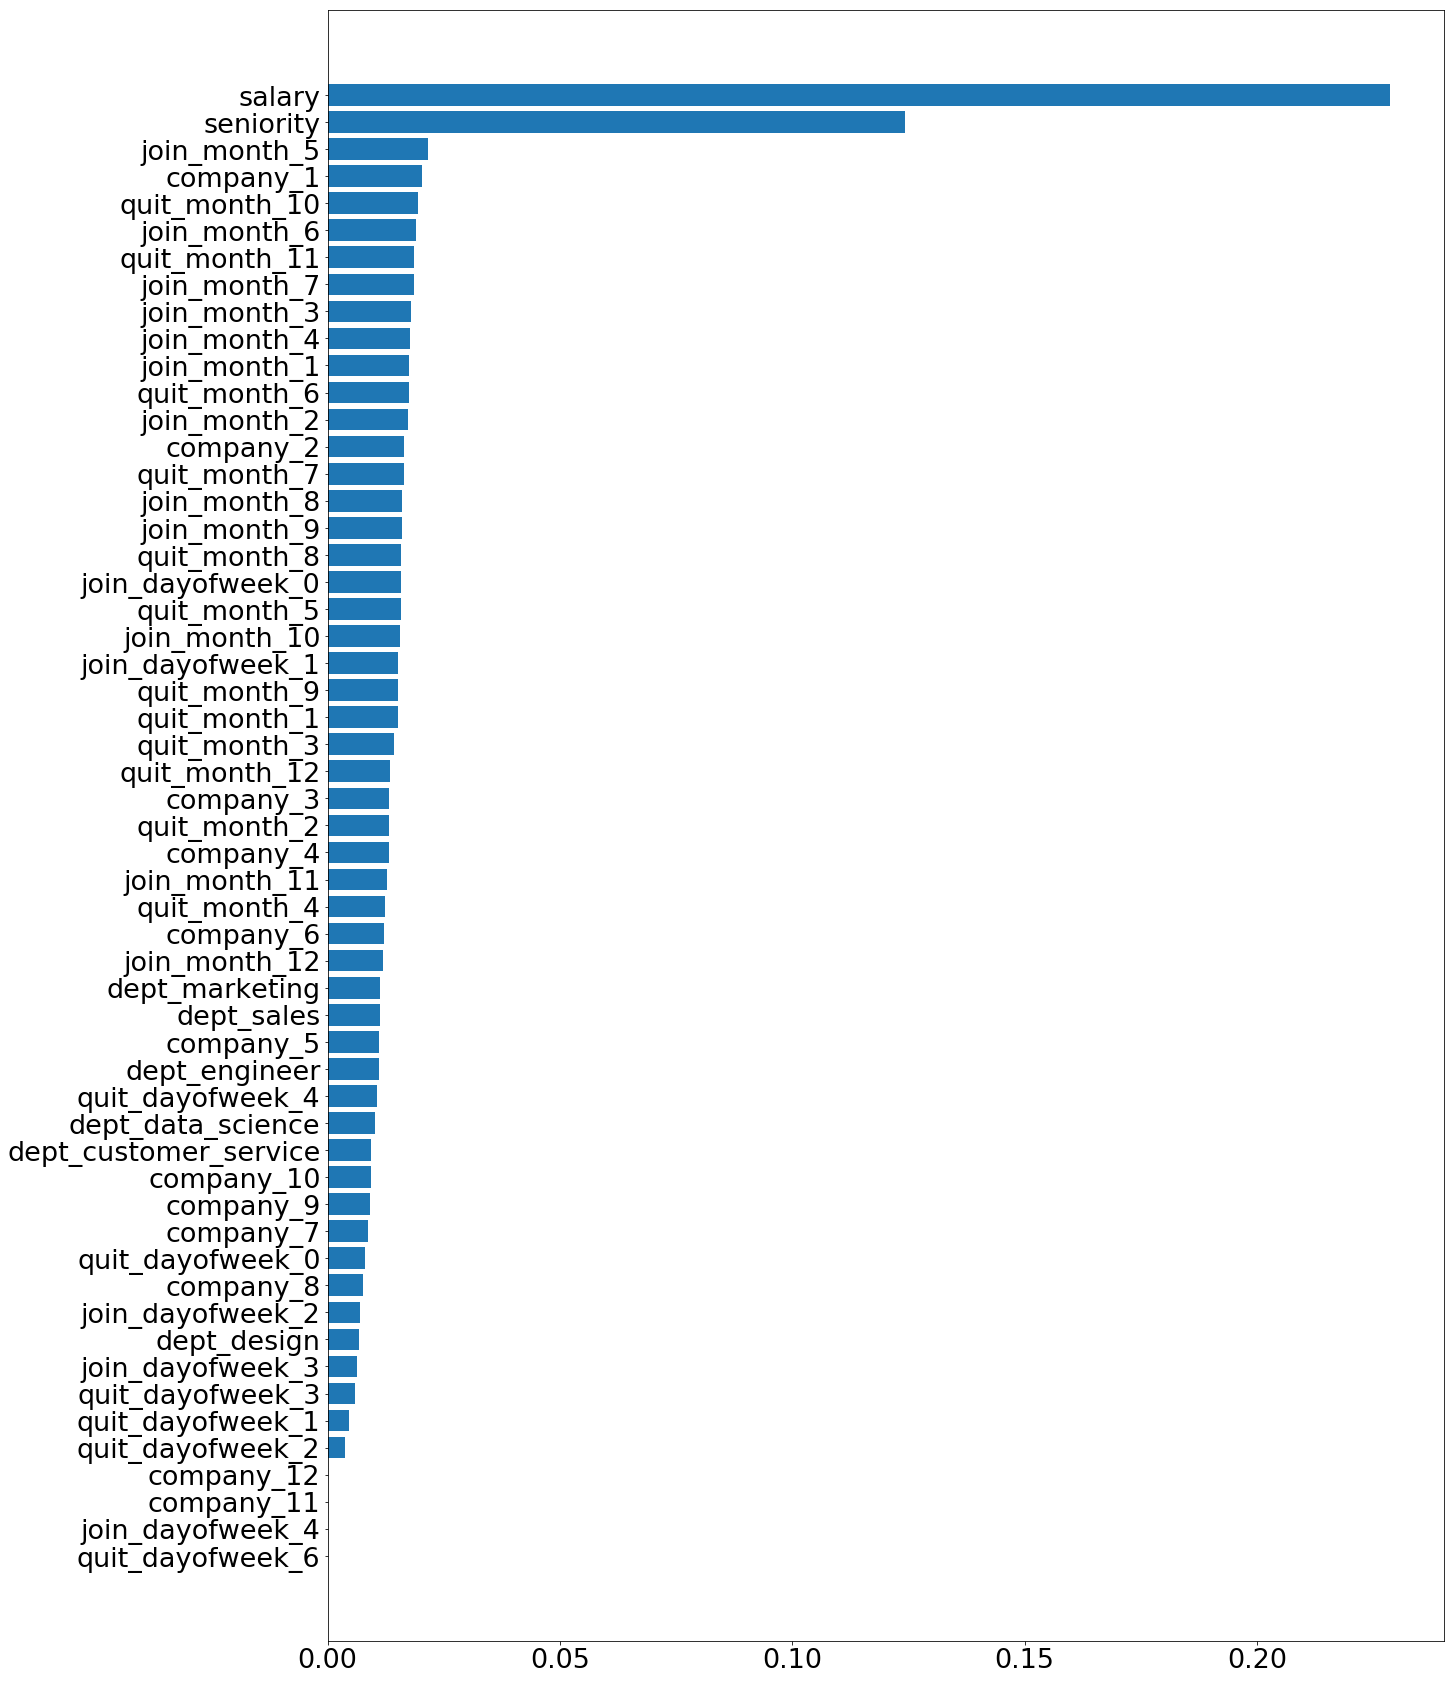

In [35]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(train_x, train_y)
rpredicted = regr.predict(test_x)
a = zip(regr.feature_importances_, df_churned_x)
a = sorted(a)
xplot = [x[1] for x in a]
yplot = [y[0] for y in a]
dummy=list(range(len(a)))
plt.rcParams.update({'font.size': 27})
plt.rcParams['figure.figsize'] = 20, 30
plt.close()
plt.barh(dummy,yplot,tick_label=xplot)
plt.show()

In [36]:
from sklearn.metrics import mean_squared_error
RMSE=mean_squared_error(test_y, rpredicted)**(1/2)
RMSE

325.55341521573433

# Key Take Aways

>Both models confirmed that Salary and Seniority are the biggest driving factor for the length of stay of an employee at a compnay, with the additional information from Lasso that salary positively affect the length of stay, while seniority negatively affect the length of stay. This makes certain intuitive sense as the larger a slary an employee earn the less likely for them to leave a company, while a more senior empolyee will be the reasons to leave, such as closer to retirement age or having access to better oppurtunities.

# Future Directions

>Additional data can help predict employee length of stay. Including their demographics, such as age, gender, marital status etc. Information on employee satisfaction about their job and their company such as survey data can be also be very helpful. Company information such as if the company is doing well (postive revenue, year-end bonus distributed or not etc.) can also give a better prediction.